In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(CellChat) 
library(ComplexHeatmap)
library(here)

# For co-cultures with unsorted fibroblasts and 1:1 mix CD34hi/lo: combined fibroblast clusters
# For co-cultures with sorted CD34hi/lo fibroblasts: subset on fibroblast cluster of interest

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta versi

# Data Prep

Example script (organoid + CD34hi/lo 1:1 mix) to generate the d_* rds files for the downstream analysis:

```
INTepi <- readRDS(here("data", "INTepi.rds")) # Deposited at Zenodo
unique(INTepi$orig.ident)
head(INTepi@meta.data$curatedCLUST)
Idents(object = INTepi) <- "curatedCLUST"
unique(INTepi@active.ident)

aug21 <- readRDS(here("data", "aug21_WT.rds")) # Deposited at Zenodo
aug21
d_org_CD34hilo <- aug21[[2]]
rm(aug21)

# --- 
# Label transfer
# ---

WTorg_CD34hilo <- subset(INTepi, subset = orig.ident == "WTorg_CD34hilo")
head(Cells(WTorg_CD34hilo))

WTorg_CD34hilo <- RenameCells(WTorg_CD34hilo, new.names = strsplit(Cells(WTorg_CD34hilo), split = "_18"))
head(Cells(WTorg_CD34hilo))
head(Idents(WTorg_CD34hilo))

d_org_CD34hilo <- AddMetaData(d_org_CD34hilo, metadata = Idents(WTorg_CD34hilo), col.name = "finalCLUST")
head(d_org_CD34hilo@meta.data)
saveRDS(d_org_CD34hilo, file = here("data", "d_org_CD34hilo.rds"))
rm(d_org_CD34hilo)

# ---
# QC
# ---

d_org_CD34hilo <- readRDS(here("data", "d_org_CD34hilo.rds"))
d_org_CD34hilo <- subset(d_org_CD34hilo, subset = mito_content < 3 &
  nCount_RNA > 4800 &
  nCount_RNA < 50000 &
  nFeature_RNA > 2000 &
  nFeature_RNA < 7600)

# ---
# Identify CD34hi/lo fibroblast clusters
# ---

d_org_CD34hilo
Idents(d_org_CD34hilo) <- "seurat_clusters"
d_org_CD34hilo@meta.data$old.clust <- d_org_CD34hilo@active.ident

DimPlot(d_org_CD34hilo, reduction = "umap")
FeaturePlot(d_org_CD34hilo, reduction = "umap", features = "Cd34")
# cluster 2: cd34hi; cluster 3: cd34lo
d_org_CD34hilo@meta.data$old.clust <-
  RenameIdents(SetIdent(d_org_CD34hilo, value = "old.clust"), "2" = "fCD34hi")@active.ident
d_org_CD34hilo@meta.data$old.clust <-
  RenameIdents(SetIdent(d_org_CD34hilo, value = "old.clust"), "3" = "fCD34lo")@active.ident
head(d_org_CD34hilo@meta.data) 
 
# ---
# Merge cluster identity across finalCLUST and old.clust
# ---

d_org_CD34hilo@meta.data$finalCLUST <- coalesce(d_org_CD34hilo@meta.data$finalCLUST, d_org_CD34hilo@meta.data$old.clust)
head(d_org_CD34hilo@meta.data)
Idents(d_org_CD34hilo) <- "finalCLUST"
DimPlot(d_org_CD34hilo, reduction = "umap")
unique(Idents(d_org_CD34hilo))

saveRDS(d_org_CD34hilo, file = here("data", "d_org_CD34hilo_clustered.rds"))
```

In [ ]:
# ---
# org_CD34hilo
# ---

d_org_CD34hilo <- readRDS(here("data", "d_org_CD34hilo_clustered.rds"))
Idents(d_org_CD34hilo) <- "finalCLUST"

d_org_CD34hilo@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_org_CD34hilo, value = "finalCLUST"), "fCD34hi" = "fib")@active.ident
d_org_CD34hilo@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_org_CD34hilo, value = "finalCLUST_merged"), "fCD34lo" = "fib")@active.ident

Idents(d_org_CD34hilo) <- "finalCLUST_merged"
DimPlot(d_org_CD34hilo, reduction = "umap")
# saveRDS(d_org_CD34hilo, file = here("data", "d_org_CD34hilo_clustered.rds"))

# Remove outliers
finalCLUST_cc <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte",
  "fib" # !
)

d_org_CD34hilo <- subset(d_org_CD34hilo, subset = finalCLUST_merged %in% finalCLUST_cc)
d_org_CD34hilo@meta.data$finalCLUST_merged <- droplevels(d_org_CD34hilo@meta.data$finalCLUST_merged) # !
DimPlot(d_org_CD34hilo, reduction = "umap")

# CellChat analysis
cc_org_CD34hilo <- createCellChat(
  object = d_org_CD34hilo,
  meta = d_org_CD34hilo@meta.data,
  group.by = "finalCLUST_merged",
  assay = "RNA",
  do.sparse = TRUE
)

cc_org_CD34hilo@DB <- CellChatDB.mouse
cc_org_CD34hilo <- subsetData(cc_org_CD34hilo)
# future::plan("multisession", workers = 12) # do parallel
cc_org_CD34hilo <- identifyOverExpressedGenes(cc_org_CD34hilo)
cc_org_CD34hilo <- identifyOverExpressedInteractions(cc_org_CD34hilo)
cc_org_CD34hilo <- computeCommunProb(cc_org_CD34hilo)
cc_org_CD34hilo <- filterCommunication(cc_org_CD34hilo, min.cells = 12)
cc_org_CD34hilo <- computeCommunProbPathway(cc_org_CD34hilo, thresh = 0.05)
cc_org_CD34hilo <- aggregateNet(cc_org_CD34hilo)
cc_org_CD34hilo <- netAnalysis_computeCentrality(cc_org_CD34hilo, slot.name = "netP")
# netAnalysis_signalingRole_scatter(cc_org_CD34hilo)
# saveRDS(cc_org_CD34hilo, here("data", "cc_org_CD34hilo_merged.rds"))

# ---
# fibWT
# * Optional: Add condition prefix to cellID,
# d_fibWT <- RenameCells(d_fibWT, add.cell.id = "fibWT_")
# ---

d_fibWT <- readRDS(here("data", "d_fibWT_clustered.rds"))
Idents(d_fibWT) <- "finalCLUST"

d_fibWT@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_fibWT, value = "finalCLUST"), "fCD34hi" = "fib")@active.ident
d_fibWT@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_fibWT, value = "finalCLUST_merged"), "fCD34lo" = "fib")@active.ident

Idents(d_fibWT) <- "finalCLUST_merged"
DimPlot(d_fibWT, reduction = "umap")
saveRDS(d_fibWT, file = here("data", "d_fibWT_clustered.rds"))

# Remove outliers

finalCLUST_cc <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte",
  "fib" # !
)

d_fibWT <- subset(d_fibWT, subset = finalCLUST_merged %in% finalCLUST_cc)
d_fibWT@meta.data$finalCLUST_merged <- droplevels(d_fibWT@meta.data$finalCLUST_merged) # !
DimPlot(d_fibWT, reduction = "umap")


# CellChat analysis

cc_fibWT <- createCellChat(
  object = d_fibWT,
  meta = d_fibWT@meta.data,
  group.by = "finalCLUST_merged",
  assay = "RNA",
  do.sparse = TRUE
)

cc_fibWT@DB <- CellChatDB.mouse

cc_fibWT <- subsetData(cc_fibWT)
# future::plan("multisession", workers = 12) # do parallel
cc_fibWT <- identifyOverExpressedGenes(cc_fibWT)
cc_fibWT <- identifyOverExpressedInteractions(cc_fibWT)
cc_fibWT <- computeCommunProb(cc_fibWT)
cc_fibWT <- filterCommunication(cc_fibWT, min.cells = 12)
cc_fibWT <- computeCommunProbPathway(cc_fibWT, thresh = 0.05)
cc_fibWT <- aggregateNet(cc_fibWT)
cc_fibWT <- netAnalysis_computeCentrality(cc_fibWT, slot.name = "netP")
# netAnalysis_signalingRole_scatter(cc_fibWT)
saveRDS(cc_fibWT, here("data", "cc_fibWT_merged.rds"))

# ---
# org_CD34hi
# ---

d_org_CD34hi <- readRDS(here("data", "d_org_CD34hi_clustered.rds"))
Idents(d_org_CD34hi) <- "finalCLUST"
d_org_CD34hi@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_org_CD34hi, value = "finalCLUST"), "fCD34hi" = "fib")@active.ident
# d_org_CD34hi@meta.data$finalCLUST_merged <-
#   RenameIdents(SetIdent(d_org_CD34hi, value = "finalCLUST_merged"), "fCD34lo" = "fib")@active.ident
Idents(d_org_CD34hi) <- "finalCLUST_merged"
DimPlot(d_org_CD34hi, reduction = "umap")
# saveRDS(d_org_CD34hi, file = here("data", "d_org_CD34hi_clustered.rds"))

# Remove outliers
finalCLUST_cc <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte",
  "fib" # !
)
d_org_CD34hi <- subset(d_org_CD34hi, subset = finalCLUST_merged %in% finalCLUST_cc)
d_org_CD34hi@meta.data$finalCLUST_merged <- droplevels(d_org_CD34hi@meta.data$finalCLUST_merged) # !
DimPlot(d_org_CD34hi, reduction = "umap")

# CellChat analysis
cc_org_CD34hi <- createCellChat(
  object = d_org_CD34hi,
  meta = d_org_CD34hi@meta.data,
  group.by = "finalCLUST_merged",
  assay = "RNA",
  do.sparse = TRUE
)
cc_org_CD34hi@DB <- CellChatDB.mouse
cc_org_CD34hi <- subsetData(cc_org_CD34hi)
# future::plan("multisession", workers = 12) # do parallel
cc_org_CD34hi <- identifyOverExpressedGenes(cc_org_CD34hi)
cc_org_CD34hi <- identifyOverExpressedInteractions(cc_org_CD34hi)
cc_org_CD34hi <- computeCommunProb(cc_org_CD34hi)
cc_org_CD34hi <- filterCommunication(cc_org_CD34hi, min.cells = 12)
cc_org_CD34hi <- computeCommunProbPathway(cc_org_CD34hi, thresh = 0.05)
cc_org_CD34hi <- aggregateNet(cc_org_CD34hi)
cc_org_CD34hi <- netAnalysis_computeCentrality(cc_org_CD34hi, slot.name = "netP")
# netAnalysis_signalingRole_scatter(cc_org_CD34hi)
# saveRDS(cc_org_CD34hi, here("data", "cc_org_CD34hi_merged.rds"))

# ---
# org_CD34lo
# ---

d_org_CD34lo <- readRDS(here("data", "d_org_CD34lo_clustered.rds"))
Idents(d_org_CD34lo) <- "finalCLUST"
# d_org_CD34lo@meta.data$finalCLUST_merged <-
#   RenameIdents(SetIdent(d_org_CD34lo, value = "finalCLUST"), "fCD34hi" = "fib")@active.ident
d_org_CD34lo@meta.data$finalCLUST_merged <-
  RenameIdents(SetIdent(d_org_CD34lo, value = "finalCLUST"), "fCD34lo" = "fib")@active.ident
Idents(d_org_CD34lo) <- "finalCLUST_merged"
DimPlot(d_org_CD34lo, reduction = "umap")
# saveRDS(d_org_CD34lo, file = here("data", "d_org_CD34lo_clustered.rds"))

# Remove outliers and CD34hi fibs
finalCLUST_cc <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte",
  "fib" # !
)
d_org_CD34lo <- subset(d_org_CD34lo, subset = finalCLUST_merged %in% finalCLUST_cc)
d_org_CD34lo@meta.data$finalCLUST_merged <- droplevels(d_org_CD34lo@meta.data$finalCLUST_merged) # !
DimPlot(d_org_CD34lo, reduction = "umap")

# CellChat analysis
cc_org_CD34lo <- createCellChat(
  object = d_org_CD34lo,
  meta = d_org_CD34lo@meta.data,
  group.by = "finalCLUST_merged",
  assay = "RNA",
  do.sparse = TRUE
)
cc_org_CD34lo@DB <- CellChatDB.mouse
cc_org_CD34lo <- subsetData(cc_org_CD34lo)
# future::plan("multisession", workers = 12) # do parallel
cc_org_CD34lo <- identifyOverExpressedGenes(cc_org_CD34lo)
cc_org_CD34lo <- identifyOverExpressedInteractions(cc_org_CD34lo)
cc_org_CD34lo <- computeCommunProb(cc_org_CD34lo)
cc_org_CD34lo <- filterCommunication(cc_org_CD34lo, min.cells = 12)
cc_org_CD34lo <- computeCommunProbPathway(cc_org_CD34lo, thresh = 0.05)
cc_org_CD34lo <- aggregateNet(cc_org_CD34lo)
cc_org_CD34lo <- netAnalysis_computeCentrality(cc_org_CD34lo, slot.name = "netP")
# netAnalysis_signalingRole_scatter(cc_org_CD34lo)
# saveRDS(cc_org_CD34lo, here("data", "cc_org_CD34lo_merged.rds"))

# CellChat Analysis

In [15]:
# ------
# ---
# MERGING CELLCHAT OBJECTS
# ---
# ------

cc_fibWT <- readRDS(here("Figure1_S1", "data", "cc_fibWT_merged.rds"))
cc_org_CD34hilo <- readRDS(here("Figure1_S1", "data", "cc_org_CD34hilo_merged.rds"))
cc_org_CD34hi <- readRDS(here("Figure1_S1", "data", "cc_org_CD34hi_merged.rds"))
cc_org_CD34lo <- readRDS(here("Figure1_S1", "data", "cc_org_CD34lo_merged.rds"))

cc_merged <- mergeCellChat(
  list(cc_fibWT, cc_org_CD34hilo, cc_org_CD34hi, cc_org_CD34lo),
  add.names = c("fibWT", "CD34hilo", "CD34hi", "CD34lo"),
  cell.prefix = TRUE # Since I didn't do it upfront
)
head(cc_merged@meta)

Warning message in mergeCellChat(list(cc_fibWT, cc_org_CD34hilo, cc_org_CD34hi, :
"Prefix cell names!"


The cell barcodes in merged 'meta' is  AAACCCACAGCTTCCT-1 AAACCCAGTTCGAGCC-1 AAACGAAAGAAGGATG-1 AAACGAAAGGAAAGGT-1 AAACGAAAGTTAACGA-1 AAACGAACACCAGCTG-1 


Warning message in mergeCellChat(list(cc_fibWT, cc_org_CD34hilo, cc_org_CD34hi, :
"The cell barcodes in merged 'meta' is different from those in the used data matrix.
              We now simply assign the colnames in the data matrix to the rownames of merged 'mata'!"
Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



,orig.ident,nCount_RNA,nFeature_RNA,mito_content,rfp_content,gfp_content,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CCDiff,seurat_clusters,finalCLUST,old.clust,finalCLUST_merged,datasets
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
AAACCCACAGCTTCCT-1_fibWT,cocultWTFib,10761,3163,0.9478673,0.009292817,0,17183,3206,0.09172818,-0.035993356,Cycling,cocultWTFib,0.12772154,4,fCD34hi,fCD34hi,fib,fibWT
AAACCCAGTTCGAGCC-1_fibWT,cocultWTFib,15485,3811,1.2334517,0.000000000,0,17347,3811,0.04773247,-0.003213944,Cycling,cocultWTFib,0.05094641,2,fCD34hi,fCD34hi,fib,fibWT
AAACGAAAGAAGGATG-1_fibWT,cocultWTFib,16689,3775,1.2702978,0.000000000,0,17508,3775,0.04882882,-0.047011565,Cycling,cocultWTFib,0.09584038,2,fCD34hi,fCD34hi,fib,fibWT
AAACGAAAGGAAAGGT-1_fibWT,cocultWTFib,5756,2126,1.4767199,0.000000000,0,16159,2915,0.04299459,-0.003852567,Cycling,cocultWTFib,0.04684716,9,Late Enterocyte,9,Late Enterocyte,fibWT
AAACGAAAGTTAACGA-1_fibWT,cocultWTFib,40330,4714,0.4512770,0.000000000,0,18645,3719,0.01198900,-0.003207270,Cycling,cocultWTFib,0.01519627,5,TA 1,fCD34hi,TA 1,fibWT
AAACGAACACCAGCTG-1_fibWT,cocultWTFib,29829,5235,0.8917496,0.003352442,0,18905,5016,0.31804191,0.452043743,Highly cycling,cocultWTFib,-0.13400183,7,fCD34hi,fCD34hi,fib,fibWT


## Interaction level analysis

In [28]:
epiPOPs <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte"
)

path_org_fibWT <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "net"
)[[1]]
path_org_fibWT["condition"] <- "fibWT"
path_org_fibWT$Columns <- str_c("fibWT_", path_org_fibWT$target)

path_org_cd34hilo <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "net"
)[[2]]
path_org_cd34hilo["condition"] <- "cd34hilo"
path_org_cd34hilo$Columns <- str_c("cd34hilo_", path_org_cd34hilo$target)

path_org_cd34hi <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "net"
)[[3]]
path_org_cd34hi["condition"] <- "cd34hi"
path_org_cd34hi$Columns <- str_c("cd34hi_", path_org_cd34hi$target)

path_org_cd34lo <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "net"
)[[4]]
path_org_cd34lo["condition"] <- "cd34lo"
path_org_cd34lo$Columns <- str_c("cd34lo_", path_org_cd34lo$target)

dCellComm_prob <- bind_rows(
  path_org_fibWT, path_org_cd34hilo, path_org_cd34hi, path_org_cd34lo,
  # .id = "condition"
) %>% group_by(target, pathway_name)
head(dCellComm_prob)
# unique(dCellComm_prob$Columns)
write.csv(dCellComm_prob, here("Figure1_S1", "data", "CC_resultsInteraction.csv"), row.names = FALSE)

source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence,condition,Columns
<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
fib,revCSC,Tgfb1,TGFbR1_R2,0.0010917820,0.00,TGFB1_TGFBR1_TGFBR2,Tgfb1 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350,fibWT,fibWT_revCSC
fib,revCSC,Tgfb2,TGFbR1_R2,0.0002637324,0.00,TGFB2_TGFBR1_TGFBR2,Tgfb2 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350,fibWT,fibWT_revCSC
fib,TA 2,Tgfb2,TGFbR1_R2,0.0003007076,0.03,TGFB2_TGFBR1_TGFBR2,Tgfb2 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350,fibWT,fibWT_TA 2
fib,TA 2,Tgfb1,ACVR1B_TGFbR2,0.0011561641,0.00,TGFB1_ACVR1B_TGFBR2,Tgfb1 - (Acvr1b+Tgfbr2),TGFb,Secreted Signaling,PMID: 27449815,fibWT,fibWT_TA 2
fib,TA 2,Tgfb2,ACVR1B_TGFbR2,0.0002793793,0.00,TGFB2_ACVR1B_TGFBR2,Tgfb2 - (Acvr1b+Tgfbr2),TGFb,Secreted Signaling,PMID: 27449815,fibWT,fibWT_TA 2
fib,revCSC,Tgfb2,ACVR1_TGFbR,0.0004613335,0.01,TGFB2_ACVR1_TGFBR1,Tgfb2 - (Acvr1+Tgfbr1),TGFb,Secreted Signaling,PMID: 29376829,fibWT,fibWT_revCSC


## Pathway level analysis

In [18]:
epiPOPs <- c(
  "CSC", "proCSC", "revCSC",
  "TA 1", "TA 2",
  "ER Stress", "Goblet / DCS",
  "Early Enterocyte", "Late Enterocyte"
)

path_org_fibWT <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "netP"
)[[1]]
path_org_fibWT["condition"] <- "fibWT"
path_org_fibWT$Columns <- str_c("fibWT_", path_org_fibWT$target)

path_org_cd34hilo <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "netP"
)[[2]]
path_org_cd34hilo["condition"] <- "cd34hilo"
path_org_cd34hilo$Columns <- str_c("cd34hilo_", path_org_cd34hilo$target)

path_org_cd34hi <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "netP"
)[[3]]
path_org_cd34hi["condition"] <- "cd34hi"
path_org_cd34hi$Columns <- str_c("cd34hi_", path_org_cd34hi$target)

path_org_cd34lo <- subsetCommunication(cc_merged,
  sources.use = c("fib"), targets.use = epiPOPs,
  slot.name = "netP"
)[[4]]
path_org_cd34lo["condition"] <- "cd34lo"
path_org_cd34lo$Columns <- str_c("cd34lo_", path_org_cd34lo$target)

dCellComm_prob <- bind_rows(
  path_org_fibWT, path_org_cd34hilo, path_org_cd34hi, path_org_cd34lo
  # .id = "dataset"
) %>% group_by(target, pathway_name)
head(dCellComm_prob)
unique(dCellComm_prob$Columns)
write.csv(dCellComm_prob, here("Figure1_S1", "data", "CC_resultsPathway.csv"), row.names = FALSE)

source,target,pathway_name,prob,pval,condition,Columns
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
fib,CSC,ANGPTL,0.0184395026,0.000000000,fibWT,fibWT_CSC
fib,CSC,COLLAGEN,0.4513931015,0.002000000,fibWT,fibWT_CSC
fib,CSC,FN1,0.0863622559,0.003333333,fibWT,fibWT_CSC
fib,CSC,IGF,0.0003981181,0.000000000,fibWT,fibWT_CSC
fib,CSC,JAM,0.0048054382,0.000000000,fibWT,fibWT_CSC
fib,CSC,LAMININ,0.0383185775,0.003076923,fibWT,fibWT_CSC


[1] "fibWT_CSC"                 "fibWT_ER Stress"          
 [3] "fibWT_Early Enterocyte"    "fibWT_Goblet / DCS"       
 [5] "fibWT_Late Enterocyte"     "fibWT_TA 1"               
 [7] "fibWT_TA 2"                "fibWT_proCSC"             
 [9] "fibWT_revCSC"              "cd34hilo_CSC"             
[11] "cd34hilo_ER Stress"        "cd34hilo_Early Enterocyte"
[13] "cd34hilo_Goblet / DCS"     "cd34hilo_Late Enterocyte" 
[15] "cd34hilo_TA 1"             "cd34hilo_TA 2"            
[17] "cd34hilo_proCSC"           "cd34hilo_revCSC"          
[19] "cd34hi_CSC"                "cd34hi_ER Stress"         
[21] "cd34hi_Early Enterocyte"   "cd34hi_Goblet / DCS"      
[23] "cd34hi_Late Enterocyte"    "cd34hi_TA 1"              
[25] "cd34hi_TA 2"               "cd34hi_proCSC"            
[27] "cd34hi_revCSC"             "cd34lo_CSC"               
[29] "cd34lo_ER Stress"          "cd34lo_Early Enterocyte"  
[31] "cd34lo_Goblet / DCS"       "cd34lo_Late Enterocyte"   
[33] "cd34lo_TA 1"               "cd34lo_TA 2"              
[35] "cd34lo_proCSC"             "cd34lo_revCSC"

## Generate Pathway Heatmaps

,source,target,pathway_name,prob,pval,condition,Columns
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,fib,CSC,ANGPTL,0.0184395026,0.000000000,fibWT,fibWT_CSC
2,fib,CSC,COLLAGEN,0.4513931015,0.002000000,fibWT,fibWT_CSC
3,fib,CSC,FN1,0.0863622559,0.003333333,fibWT,fibWT_CSC
4,fib,CSC,IGF,0.0003981181,0.000000000,fibWT,fibWT_CSC
5,fib,CSC,JAM,0.0048054382,0.000000000,fibWT,fibWT_CSC
6,fib,CSC,LAMININ,0.0383185775,0.003076923,fibWT,fibWT_CSC


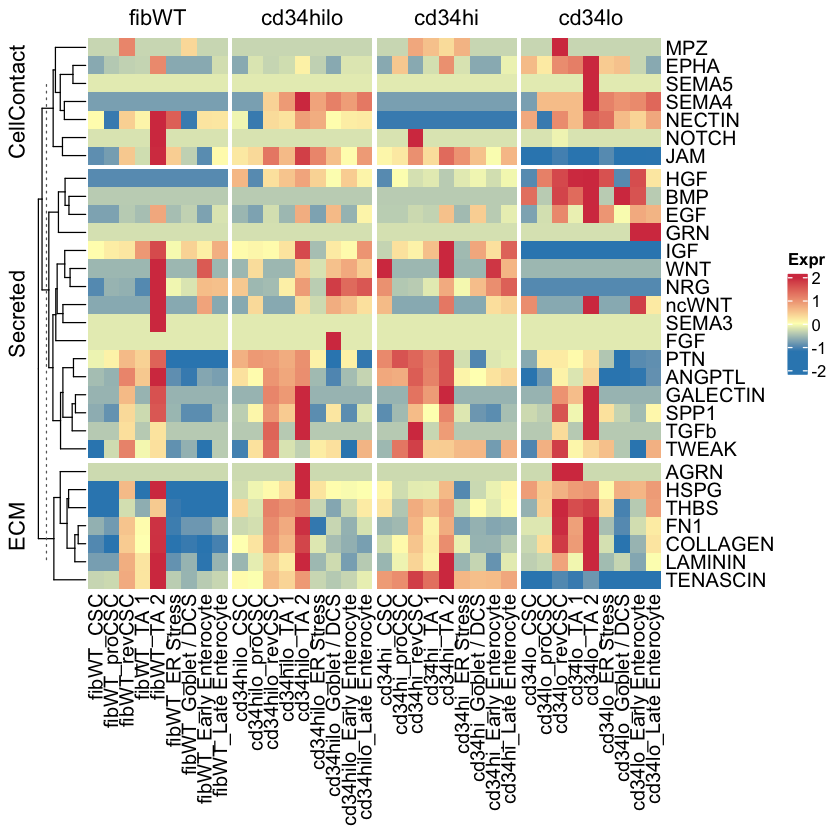

In [27]:
dCC_pathway <- read.csv(here("Figure1_S1", "data", "CC_resultsPathway.csv"))
head(dCC_pathway)

dCC_pathway$condition <- factor(
  dCC_pathway$condition,
  levels = c("fibWT", "cd34hilo", "cd34hi", "cd34lo")
)

dCC_pathway$Columns <- factor(
  dCC_pathway$Columns,
  levels = c(
    "fibWT_CSC",
    "fibWT_proCSC",
    "fibWT_revCSC",
    "fibWT_TA 1",
    "fibWT_TA 2",
    "fibWT_ER Stress",
    "fibWT_Goblet / DCS",
    "fibWT_Early Enterocyte",
    "fibWT_Late Enterocyte",
    "cd34hilo_CSC",
    "cd34hilo_proCSC",
    "cd34hilo_revCSC",
    "cd34hilo_TA 1",
    "cd34hilo_TA 2",
    "cd34hilo_ER Stress",
    "cd34hilo_Goblet / DCS",
    "cd34hilo_Early Enterocyte",
    "cd34hilo_Late Enterocyte",
    "cd34hi_CSC",
    "cd34hi_proCSC",
    "cd34hi_revCSC",
    "cd34hi_TA 1",
    "cd34hi_TA 2",
    "cd34hi_ER Stress",
    "cd34hi_Goblet / DCS",
    "cd34hi_Early Enterocyte",
    "cd34hi_Late Enterocyte",
    "cd34lo_CSC",
    "cd34lo_proCSC",
    "cd34lo_revCSC",
    "cd34lo_TA 1",
    "cd34lo_TA 2",
    "cd34lo_ER Stress",
    "cd34lo_Goblet / DCS",
    "cd34lo_Early Enterocyte",
    "cd34lo_Late Enterocyte"
  )
)
# head(dCC_pathway)

dmat_scaledpath <- dCC_pathway %>%
  # filter(Cluster != "fibroblast") %>%
  ungroup() %>%
  select(pathway_name, prob, Columns) %>%
  pivot_wider(names_from = Columns, values_from = prob)
dmat_scaledpath <- data.table::transpose(dmat_scaledpath, keep.names = "names") %>% column_to_rownames(var = "names")

names(dmat_scaledpath) <- dmat_scaledpath %>%
  slice(1) %>%
  unlist()
dmat_scaledpath <- dmat_scaledpath %>% slice(-1)
# dmat_scaledpath
dmat_scaledpath[is.na(dmat_scaledpath)] <- 0
dmat_scaledpath <- dmat_scaledpath %>%
  mutate(across(everything(), as.double)) %>%
  rownames_to_column(var = "pathway_name") %>%
  mutate(across(where(is.numeric), scale))
# head(dmat_scaledpath)

dmat_scaledpath <- data.table::transpose(dmat_scaledpath, keep.names = "names") %>% column_to_rownames(var = "names")
names(dmat_scaledpath) <- dmat_scaledpath %>%
  slice(1) %>%
  unlist()
dmat_scaledpath <- dmat_scaledpath %>% slice(-1)
dmat_scaledpath <- dmat_scaledpath %>%
  mutate(across(everything(), as.numeric)) %>%
  rownames_to_column(var = "names") %>%
  arrange(names) %>%
  column_to_rownames(var = "names")
# head(dmat_scaledpath)

htmp_colsplit_condition <- dCC_pathway %>%
  ungroup() %>%
  select(condition, Columns) %>%
  distinct() %>%
  column_to_rownames(var = "Columns")
# head(htmp_colsplit_condition)

dCCanno_ecm <- CellChatDB.mouse$interaction %>%
  select(pathway_name, annotation) %>%
  distinct() %>%
  filter(annotation == "ECM-Receptor")
dCCanno_cellcont <- CellChatDB.mouse$interaction %>%
  select(pathway_name, annotation) %>%
  distinct() %>%
  filter(annotation == "Cell-Cell Contact")
dCCanno_secreted <- CellChatDB.mouse$interaction %>%
  select(pathway_name, annotation) %>%
  distinct() %>%
  filter(annotation == "Secreted Signaling")

htmp_rowsplit_ECMvsGF <- dCC_pathway %>%
  ungroup() %>%
  # select(pathway_name, interaction_name) %>%
  select(pathway_name) %>%
  distinct() %>%
  mutate(Type = case_when(
    pathway_name %in% dCCanno_ecm$pathway_name ~ "ECM",
    pathway_name %in% dCCanno_cellcont$pathway_name ~ "CellContact",
    pathway_name %in% dCCanno_secreted$pathway_name ~ "Secreted"
  ))

Heatmap(
  as.matrix(dmat_scaledpath),
  name = "Expr",
  column_split = htmp_colsplit_condition,
  cluster_columns = FALSE,
  cluster_column_slices = TRUE,
  column_order = levels(dCC_pathway$Columns),
  # column_order = levels(droplevels(filter(dCC_pathway, Cluster != "fibroblast")$Columns)),
  row_split = htmp_rowsplit_ECMvsGF %>%
    # select(!interaction_name) %>%
    distinct() %>%
    filter(pathway_name %in% rownames(dmat_scaledpath)) %>%
    arrange(pathway_name) %>%
    column_to_rownames(var = "pathway_name"),
  cluster_rows = TRUE,
  cluster_row_slices = TRUE,
  row_order = c(
    # "JAM", "NECTIN", "EPHA", "NOTCH", "MPZ",
    # "TENASCIN", "LAMININ", "THBS", "FN1", "COLLAGEN", "HSPG", "AGRN",
    # "ncWNT", "WNT", "TGFb", "IGF", "NRG", "EGF", "SPP1", "ANGPTL", "PTN", "GALECTIN", "TWEAK", "HGF", "GRN", "BMP",
    # "ACTIVIN", "FGF", "PDGF"
  ),
  # "SEMA3"
  col = circlize::colorRamp2(
    c(
      round(quantile(dmat_scaledpath, c(0.04, 0.96), na.rm = TRUE)[1], digits = 1),
      0,
      round(quantile(dmat_scaledpath, c(0.04, 0.96), na.rm = TRUE)[2], digits = 1)
    ),
    c("#3288BD", "#FEFEBD", "#D53E4F")
  ),
  na_col = "blue3"
)